# Проектная работа "Определение перспективного тарифа для телеком компании"

### Шаг.1 Изучение общей инфорамции о имеющихся данных 

In [55]:
#качаем библиотеки
import pandas as pd
import numpy as np
import random
import seaborn as sns
import math
from math import factorial
from math import ceil
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import norm
import math as mt
random.seed(42)

In [56]:
#качаем датасеты
calls=pd.read_csv('/datasets/calls.csv') 
internet=pd.read_csv('/datasets/internet.csv',index_col=0)
messages=pd.read_csv('/datasets/messages.csv')
tariffs=pd.read_csv('/datasets/tariffs.csv')
users=pd.read_csv('/datasets/users.csv')

В наличии пять датасетов, представляющие из себя 4 выборки по 500 клиентам ( звонки, сообщения, интернет и  общая иформация по клиентам) и датасет с данными о тарифах 

### Шаг 2. Подготовка данных

In [57]:
#Приведем даты в наших датасетах  к формату datetime
calls['call_date']= pd.to_datetime(calls['call_date'], format='%Y.%m.%d')
internet['session_date']=pd.to_datetime(internet['session_date'], format='%Y.%m.%d')
messages['session_date']=pd.to_datetime(messages['message_date'], format='%Y.%m.%d')
users['churn_date']=pd.to_datetime(users['churn_date'], format='%Y.%m.%d')
users['reg_date']=pd.to_datetime(users['reg_date'], format='%Y.%m.%d')

In [58]:
#Посмотрим на датасет со звонками
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [59]:
#посчитаем количество нулевых звонков
calls.loc[calls.loc[:,'duration']==0]['duration'].count()


39613

In [60]:
#количество нулевых звонков примерно 15 % от всего количества.
#выделим их пока в отдельный столбец zero_call. 
calls['zero_call']=calls.loc[calls.loc[:,'duration']==0]['duration']
calls.head()

,id,call_date,duration,user_id,zero_call
0,1000_0,2018-07-25,0.00,1000,0.0
1,1000_1,2018-08-17,0.00,1000,0.0
2,1000_2,2018-06-11,2.85,1000,NaN
3,1000_3,2018-09-21,13.80,1000,NaN
4,1000_4,2018-12-15,5.18,1000,NaN


In [61]:
#Округлим длительность звонка согласно условию тарифа,а именно до минуты всегда в большую сторону. 
#Так же сменим тип данных из 'float' в 'int' 
calls['duration']= calls['duration'].apply(np.ceil).astype(int)
#добавим столбец с месяцем
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
#сгрупируем звонки по пользователям и месяцу
data_calls = (calls
             .groupby(['user_id','month'])
             .agg({'id':'count','duration':'sum','zero_call':'count'})
             .sort_values(by=['user_id','month'])).reset_index()
#переименуем для нагляности колонку кол-во звонков в call
data_calls.rename(columns={"id":"call"},inplace=True)
#применим мультииндекс 
data_calls.set_index(['user_id','month'],inplace=True )
data_calls.head()

call  duration  zero_call
user_id month                           
1000    5        22       159          5
        6        43       172         15
        7        47       340          6
        8        52       408         10
        9        58       466         12

In [62]:
#То же проделаем с данными по интренету 
internet['mb_used']= internet['mb_used'].apply(np.ceil).astype(int)
#добавим столбец с месяцем
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
#сгрупируем сесии по пользователям и месяцу
data_internet = (internet
             .groupby(['user_id','month'])
             .agg({'id':'count','mb_used':'sum'})
             .sort_values(by=['user_id','month'])).reset_index()
#переименуем для нагляности колонку кол-во интернет-сессий в session
data_internet.rename(columns={"id":"session"},inplace=True)
#применим мультииндекс 
data_internet.set_index(['user_id','month'],inplace=True )
data_internet.head()

session  mb_used
user_id month                  
1000    5            5     2256
        6           49    23257
        7           29    14016
        8           29    14070
        9           27    14581

In [63]:
#то же самое с сообщениями
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
data_messages = (messages
             .groupby(['user_id','month'])
             .agg({'id':'count'})
             .sort_values(by=['user_id','month'])).reset_index()
#data_messages=pd.merge(data_messages,users, on='user_id',how='outer' )
#переименуем для нагляности колонку кол-во сообщений в messages
data_messages.rename(columns={"id":"messages"},inplace=True)
#применим мультииндекс 
data_messages.set_index(['user_id','month'],inplace=True )
data_messages.head()

messages
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57

In [64]:
#объединим все четыре датасета.
data_month=data_calls.join(data_messages, how='outer')
data_month=data_month.join(data_internet, how='outer')
data_month=data_month.reset_index()
data_month=pd.merge(users,data_month, on='user_id')

In [65]:
data_month.head(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,call,duration,zero_call,messages,session,mb_used
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,22.0,159.0,5.0,22.0,5.0,2256.0
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6,43.0,172.0,15.0,60.0,49.0,23257.0
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7,47.0,340.0,6.0,75.0,29.0,14016.0


In [66]:
#Для наглядности удалим имена и фамилии клиентов (одновремнно добавим свою толику в защиту личных данных пользователй)
data_month.drop(['first_name','last_name'],axis='columns', inplace=True )
data_month.head(3)

,user_id,age,churn_date,city,reg_date,tariff,month,call,duration,zero_call,messages,session,mb_used
0,1000,52,NaT,Краснодар,2018-05-25,ultra,5,22.0,159.0,5.0,22.0,5.0,2256.0
1,1000,52,NaT,Краснодар,2018-05-25,ultra,6,43.0,172.0,15.0,60.0,49.0,23257.0
2,1000,52,NaT,Краснодар,2018-05-25,ultra,7,47.0,340.0,6.0,75.0,29.0,14016.0


In [67]:
#Функция, которая возращает сумму дохода по месяцу по каждому пользователю
def income(df_users):
    calls_income=0
    internet_income=0
    messages_income=0
    total_income=0
    over=False
    calls=df_users['duration']
    internet=df_users['mb_used']
    messages=df_users['messages']
    tariff=df_users['tariff']
    


    if tariff=='smart': #определяет тариф
        if calls > 500:  #проверяет перерасход 
            calls_income  = (calls  - 500)*3 #считает оплату за перерасход по звонкам
        if internet > 15360:
            internet_income = math.ceil((internet - 15360)/1024)*200 #считает оплату за перерасход по интернету
        if messages> 50:
            messages_income=(messages-50)*3 #считает оплату за перерасход по смс
        total_income= calls_income+internet_income+ messages_income + 550 #считает общий доход с клиента
        return total_income
    #то же для второго тарифа
    if tariff=='ultra':
        if calls > 3000:
            calls_income  = (calls  - 3000)*1
        if internet > 30720:
            internet_income = math.ceil((internet - 30720)/1024)*150
        if messages> 1000:
            messages_income=(messages-1000)*1
        total_income= calls_income+internet_income+ messages_income + 1950
        return total_income
    
    else: return 0
        


In [68]:
data_month['income']=data_month.apply(income, axis=1)

In [69]:
data_month.head()


,user_id,age,churn_date,city,reg_date,tariff,month,call,duration,zero_call,messages,session,mb_used,income
0,1000,52,NaT,Краснодар,2018-05-25,ultra,5,22.0,159.0,5.0,22.0,5.0,2256.0,1950.0
1,1000,52,NaT,Краснодар,2018-05-25,ultra,6,43.0,172.0,15.0,60.0,49.0,23257.0,1950.0
2,1000,52,NaT,Краснодар,2018-05-25,ultra,7,47.0,340.0,6.0,75.0,29.0,14016.0,1950.0
3,1000,52,NaT,Краснодар,2018-05-25,ultra,8,52.0,408.0,10.0,81.0,29.0,14070.0,1950.0
4,1000,52,NaT,Краснодар,2018-05-25,ultra,9,58.0,466.0,12.0,57.0,27.0,14581.0,1950.0


Подведем итог по второму шагу.

В таблице имеются данные:
  - общее кол-во  звонков, кол-во нулевых звонков, сумарное время всех звонков по месяцам
  - кол-во смс по месяцам
  - расход интернет-трафика по месяцам
  - помесячная оплата с каждого абонента 


###  Анализ данных 

### Средний расход минут, смс, интернета и "средний чек" . 

In [70]:
#Посмотрим среднее, медиану и максимальные  значения по каждому тарифу.
data_grouped = data_month.groupby('tariff').agg({'duration':('median','mean','max'),
                                                 'mb_used':('median','mean','max'),
                                                 'messages':('median','mean','max'),
                                                'income':('median','mean','max','min')})
data_grouped.round()

duration                 mb_used                   messages        \
         median   mean     max   median     mean      max   median  mean   
tariff                                                                     
smart     423.0  419.0  1435.0  16532.0  16236.0  38610.0     34.0  39.0   
ultra     528.0  545.0  1673.0  19411.0  19687.0  49789.0     51.0  61.0   

               income                          
          max  median    mean     max     min  
tariff                                         
smart   143.0  1038.0  1295.0  6770.0   550.0  
ultra   224.0  1950.0  2071.0  4800.0  1950.0

Сделаем первые выводы:
    - средняя продолжительность  звонков тарифа "ultra" больше на 24% чем "smart"
    - среднее кол-во интернет-трафика тарифа "ultra" больше на 21% чем "smart"
    - смс непопулярны в обоих тарифах 
    - доход c тарифа "ultra" больше в 2 чем "smart"

### 3.2 Гистограмма , дисперсия и среднее отклонение по видам затрат 

In [71]:
#Разобьем таблицу на две по тарифу. 
smart_data=data_month.query('tariff=="smart"')
ultra_data=data_month.query('tariff=="ultra"')

In [72]:
ultra_data.duration.dropna(inplace =True)
smart_data.duration.dropna(inplace =True)
ultra_data.mb_used.dropna(inplace =True)
smart_data.mb_used.dropna(inplace =True)
ultra_data.messages.dropna(inplace =True)
smart_data.messages.dropna(inplace =True)

### 3.2.1 Телефонные звонки

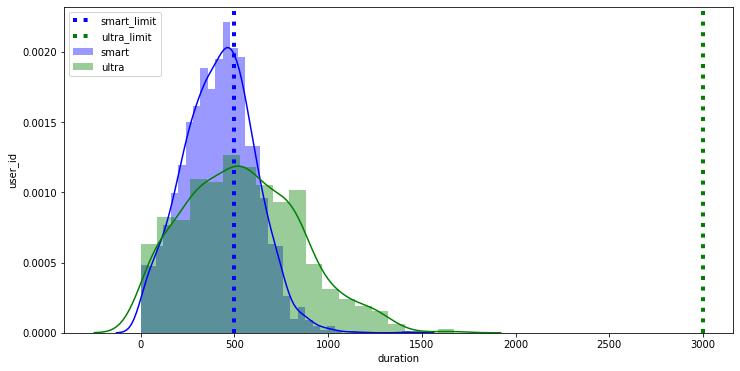

In [73]:
#Построим гистограммы двух тарифов по потраченным минутам 
plt.figure(figsize=(12,6))
sns.distplot(smart_data['duration'],color='blue',label='smart')
sns.distplot(ultra_data['duration'],color='green',label='ultra')
plt.xlabel('duration')
plt.ylabel('user_id')
plt.axvline(x=500, label='smart_limit', color='blue',linewidth=4, linestyle = ':')
plt.axvline(x=3000, label='ultra_limit', color='green',linewidth=4, linestyle = ':')
plt.legend()

In [74]:
#Посчитаем дисперсию и стандартное отклонение 
print('Дисперсия "smart": {:.2f}'.format(np.var(smart_data['duration'],ddof=1)))
print('Стандартное отклонение "smart": {:.2f}'.format(np.std(smart_data['duration'],ddof=1)))
print('Дисперсия "ultra": {:.2f}'.format(np.var(ultra_data['duration'],ddof=1)))
print('Стандартное отклонение "ultra": {:.2f}'.format(np.std(ultra_data['duration'],ddof=1)))

Дисперсия "smart": 35844.19
Стандартное отклонение "smart": 189.33
Дисперсия "ultra": 94203.42
Стандартное отклонение "ultra": 306.93


Рапсределения у обоих тарифов разные.
Так  у 'smart' распредление скошенно в лево.Это говорит о том что клиентов разговаривающих подолгу  по телефону не так много,
возможно  клиенты стараются экономить лимитное время. Судя по графику около 1/3 пользователей перерасходуют  лимит времени. 


У владельцев тарифа "ultra" медиана меньше среднего и распределение скошено вправо. Это говорит о том что в данном тарифе 
клиента больше разговаривают. При этом никто не выговаривает за лимит. 
Максимальное время 27 часов 54 минуты в месяц, при лимите в 60 часов в месяц. 

### 3.2.2 Мобильный интернет

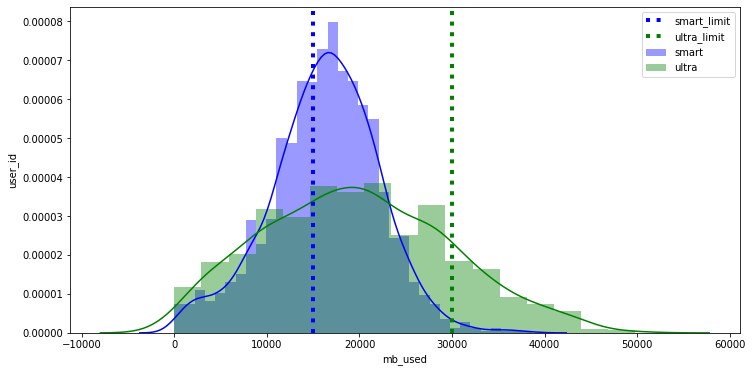

In [75]:
plt.figure(figsize=(12,6))
sns.distplot(smart_data['mb_used'],color='blue',label='smart')
sns.distplot(ultra_data['mb_used'],color='green',label='ultra')
plt.xlabel('mb_used')
plt.ylabel('user_id')
plt.axvline(x=15000, label='smart_limit', color='blue',linewidth=4, linestyle = ':')
plt.axvline(x=30000, label='ultra_limit', color='green',linewidth=4, linestyle = ':')
plt.legend()

In [76]:
print('Дисперсия "smart": {:.2f}'.format(np.var(smart_data['mb_used'],ddof=1)/1024),'Гб')
print('Стандартное отклонение "smart": {:.2f}'.format(np.std(smart_data['mb_used'],ddof=1)/1024),'Гб')
print('Дисперсия "ultra": {:.2f}'.format(np.var(ultra_data['mb_used'],ddof=1)/1024),'Гб')
print('Стандартное отклонение "ultra": {:.2f}'.format(np.std(ultra_data['mb_used'],ddof=1)/1024),'Гб')

Дисперсия "smart": 33635.84 Гб
Стандартное отклонение "smart": 5.73 Гб
Дисперсия "ultra": 96722.11 Гб
Стандартное отклонение "ultra": 9.72 Гб


Потребление мобильного интернета. 
Рапсределения обоих трафиков нормальные. Медиана и среднее почти одинаковы у обоих. 
Но вот лимиты перерасходуются у тарифа "smart" гораздо чаще чем у "ultra"

### 3.2.3 СМС

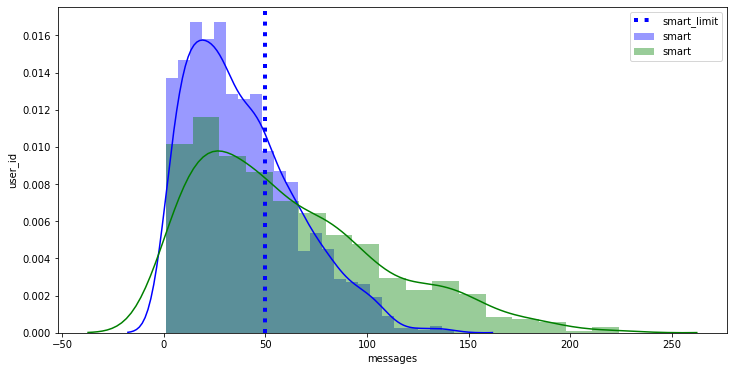

In [77]:
#построим диаграммы для смс
plt.figure(figsize=(12,6))
sns.distplot(smart_data['messages'],color='blue',label='smart')
sns.distplot(ultra_data['messages'],color='green',label='smart')
plt.xlabel('messages')
plt.ylabel('user_id')
plt.axvline(x=50, label='smart_limit', color='blue',linewidth=4, linestyle = ':')
#plt.axvline(x=1000, label='ultra_limit', color='green',linewidth=4, linestyle = ':')
plt.legend()

In [78]:
print('Дисперсия "smart": {:.2f}'.format(np.var(smart_data['messages'],ddof=1)))
print('Стандартное отклонение "smart": {:.2f}'.format(np.std(smart_data['messages'],ddof=1)))
print('Дисперсия "ultra": {:.2f}'.format(np.var(ultra_data['messages'],ddof=1)))
print('Стандартное отклонение "ultra": {:.2f}'.format(np.std(ultra_data['messages'],ddof=1)))

Дисперсия "smart": 717.59
Стандартное отклонение "smart": 26.79
Дисперсия "ultra": 2109.66
Стандартное отклонение "ultra": 45.93


 Оба графика скошены влево. Медианы меньше среднего. Есть много абонентов непользующихся данной услугой. 
При этом лимит в 50 смс для тарифа smart недостаточен примерно для 30 % пользователей. 
Лимит в 1000 смс для тарифа 'ultra' не покорился ни одному пользователю.


### 3.2.4 Нулевые звонки

Проверим гипотезу, что клиенты сбрасывают собственный звонок , когда экономят на исходящих звонках и ждут обратного звонка (бесплатного для них) 

In [79]:
#напишем функцию , которая возвращает True если есть перерасход по звонкам и False наоборот 
def over_limit (row):
    tariff=row['tariff']
    duration=row['duration']
    if tariff=='smart' and duration>500: return True
    if tariff=='ultra' and duration>3000: return True
    else: return False
data_month['over']=data_month.apply(over_limit, axis=1)
#очистим столбец call от нулевых звонков. 
data_month['call']=abs(data_month['call']-data_month['zero_call'])
data_month.head()

,user_id,age,churn_date,city,reg_date,tariff,month,call,duration,zero_call,messages,session,mb_used,income,over
0,1000,52,NaT,Краснодар,2018-05-25,ultra,5,17.0,159.0,5.0,22.0,5.0,2256.0,1950.0,False
1,1000,52,NaT,Краснодар,2018-05-25,ultra,6,28.0,172.0,15.0,60.0,49.0,23257.0,1950.0,False
2,1000,52,NaT,Краснодар,2018-05-25,ultra,7,41.0,340.0,6.0,75.0,29.0,14016.0,1950.0,False
3,1000,52,NaT,Краснодар,2018-05-25,ultra,8,42.0,408.0,10.0,81.0,29.0,14070.0,1950.0,False
4,1000,52,NaT,Краснодар,2018-05-25,ultra,9,46.0,466.0,12.0,57.0,27.0,14581.0,1950.0,False


In [80]:
#сгрупируем звонки 
zero_call=data_month.groupby(['tariff','over']).agg({'call':'sum','zero_call':'sum'})
zero_call

call  zero_call
tariff over                     
smart  False  52520.0    13499.0
       True   52126.0    12170.0
ultra  False  58348.0    13944.0

В половине случаев  тарифа 'smart' есть перерасход, но на количество нулевых звонков это не влияет.
Соотношение реальных звонков и нулевых примерно равно в обоих случаях. 

То же самое подтверждает данные по тарифу 'ultra' соотношение нулевых и реальных звонков совпадает с тарифом 'smart'.
При этом в данном тарифе нет вообще перерасхода по звонкам и клиентам нет резона экономить. 

Значимого влияния перерасход на количество нулевых звонков не оказывает. Наша гипотеза не подтвердилась 

### Шаг 4. Статистические гипотезы

### 4.1 Гипотеза о средней выручке тарифов

Гипотеза звучит так: "средняя выручка пользователей тарифов 'ultra' и 'smart' различаются.""

Нулевая гипотеза H0 будет звучат как : средние выручки двух тарифов не имеют разницы 
    

In [81]:
#проверим нулевую гипотезу
#у нас есть две выборки: smart_data и ultra_data. 

alpha = .05 # возьмем общепринятый уровень статистической значимости. 


results = st.ttest_ind(
    smart_data['income'], 
    ultra_data['income'])
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  2.9776448000521676e-158
Отвергаем нулевую гипотезу


Вероятность что средние выручки двух тарифов равны не подтвердилась. Посмотрим данные по графику:

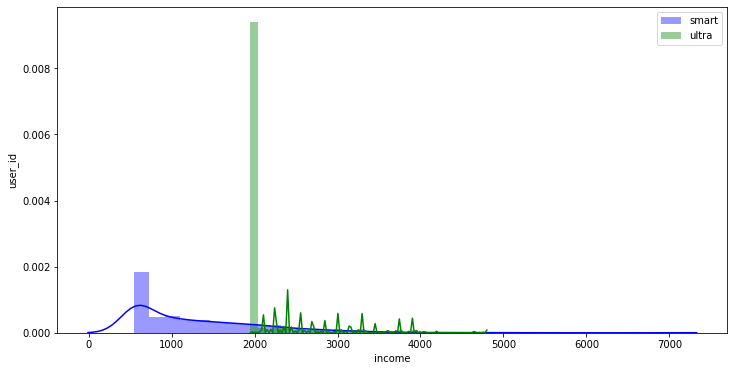

In [82]:
plt.figure(figsize=(12,6))
sns.distplot(smart_data['income'],color='blue',label='smart')
sns.distplot(ultra_data['income'],color='green',label='ultra')
plt.xlabel('income')
plt.ylabel('user_id')
plt.legend()

<font color='blue'> 
### <u>КОММЕНТАРИЙ РЕВЬЮЕРА</u>
</font>
<font color='green'>
Верно Вы с гипотезой. Графика для таких анализов - боксплоты. Они лучше отобразят сравнение.<br>
Я заметил, что Вы ими не рользуетесь. А зря! Это реально хороший график для оценки выбросов, номальности и сравнения групп (как в данном примере)

### 4.2 Гипотеза о средней выручки пользователей Москвы и других регионов 

Гипотеза звучит так: "Средняя выручка пользователей Москвы  и других регионов различаются."

Нулевая гипотеза H0 будет звучат так : "Средние выручки  Москвы и регионов не имеют разницы."

In [83]:
#привдем к нижнему регисттру названия городов
data_month['city']=data_month['city'].str.lower()
data_month['city'].value_counts()

москва             611
санкт-петербург    270
новосибирск         98
уфа                 95
краснодар           86
                  ... 
сургут               6
нижневартовск        6
химки                5
кемерово             5
иваново              2
Name: city, Length: 76, dtype: int64

In [84]:
#сделаем два среза для Москвы и регионов
data_Moscow=data_month.query('city=="москва"')
data_Zamkadye=data_month.query('city!="москва"')


In [85]:
#Гипотеза:"средняя выручка в Москве  и в других регионах различается
#сформулируем нулевую гипотезу: среднии выручки равны

alpha = .05 # возьмем общепринятый уровень статистической значимости. 

results = st.ttest_ind(
    data_Moscow['income'], 
    data_Zamkadye['income'])
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение:  0.531666503831252
Не получилось отвергнуть нулевую гипотезу


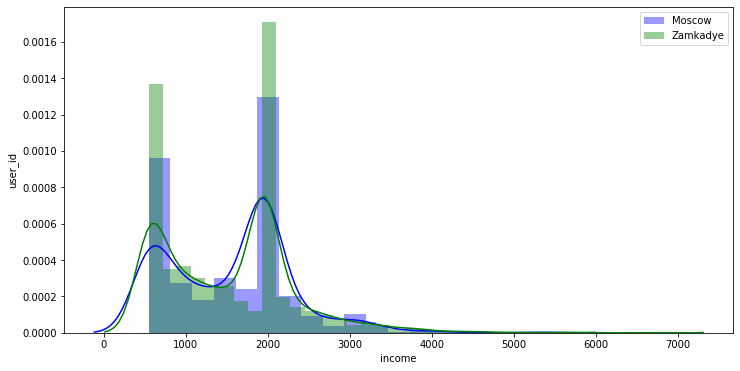

In [86]:
plt.figure(figsize=(12,6))
sns.distplot(data_Moscow['income'],color='blue',label='Moscow')
sns.distplot(data_Zamkadye['income'],color='green',label='Zamkadye')
plt.xlabel('income')
plt.ylabel('user_id')
plt.legend()

Гипотеза что клиенты в Москве больше тратят на мобильную связь не подтвердилась. Это хорошо видно на графике. 

### Шаг 5. Вывод

In [87]:
#сведем суммы метрик по тарифам в общую таблицу
data_conclusion = data_month.groupby('tariff').agg({'duration':('sum'), 
                                                 'mb_used':('sum'),
                                                 'messages':('count'),
                                                'income':('sum')
                                                   })

data_conclusion['user_count']=users.groupby('tariff')['user_id'].count()
data_conclusion

,duration,mb_used,messages,income,user_count
tariff,,,,,
smart,931577.0,36174861.0,1922,2885751.0,351
ultra,518724.0,19194598.0,795,2040000.0,149


Клиентов тарифа smart больше  ultra  в 2,35 раза. 

В среднем клиент smart в 2018 году принес: 8221 руб. 

    при этом потратил в среднем:
    
        - времени на звонки 44 часа 14 минут
        - мобильного интернета 100 Гб
        - отправил 5,5 смс 
        
В среднем клиент ultra в 2018 году принес: 13691 руб.

    при этом потратил в среднем:
    
        - времени на звонки 58 часа 
        - мобильного интернета 125,8 Гб
        - отправил 5,33 смс     
    
Если потребление услуг по тарифам отличается по звонкам на 30%, по мобильному трафику на 25%, по смс равны. То доход выше на 66%

Соответсвенно тариф ultra выгоднее для компании. 

Но большинство клиентов предпочитают  smart  и приносят большую валовую выручку. 